<h1 align=center><font size = 5>Covid19 case analysis in India</font></h1>

## Introduction
Covid19 cases are on rise in India; under this assignment, we have performed some preliminary analysis for Covid19 cases in India. In this case study we have typically worked on the below use case, 
<br>
<b>Part 1</b>
<br>
•	Identification of the distribution of Covid19 cases across various states in India. Analyzing them based using map visualization. 
<br>
•	State segmentation using clustering based on the below parameters
<br>
o	% Confirmed
<br>
o	% Active
<br>
o	% Recovered
<br>
o	% Death  
<br>
•	Represent the clusters in a map for visualization
<br>
<b>Part 2</b>
<br>
•	Try to figure out the number of hospitals out in the state using the Foursquare API, and then compare them across states.


## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Exploring Datasets with *p*andas](#0)<br>
2. [Downloading and Prepping Data](#2)<br>
3. [Data Merging and Adding Location Data](#4) <br>
4. [Further Data Analysis](#6) <br>
5. [Choropleth Maps and Visualization](#8) <br>
6. [Clustering Analysis](#10) <br>
7. [Foursquare API Analysis](#12) <br>    
</div>
<hr>

# Exploring Datasets with *pandas* and Matplotlib<a id="0"></a>

Toolkits: This lab heavily relies on [*pandas*](http://pandas.pydata.org/) and [**Numpy**](http://www.numpy.org/) for data wrangling, analysis, and visualization. The primary plotting library we will explore in this lab is [**Folium**](https://github.com/python-visualization/folium/).

Datasets: 
1. https://www.covid19india.org/ : Shows a dashboard information for number of covid19 cases Confirmed, active, recovered and deceased in India for each state. This website also has a api with crowdsourced data, https://api.covid19india.org/csv which coantains all csv data captured or collected from various authentic sources. From this api we have downloaded below  data for our analysis<br>
    a) <b>state_wise.csv : </b> which contains data for 34 states in India. For each state it has recovered, Deaths, active , confirmed, increase from previous day. <br>
    b) <b>statewise_tested_numbers_data: </b> which contains the cummulative covid19 test count for each day for each state, along with all other information e.g. number of beds, population for that state, %positive , % negative e.t.c.

In [135]:
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import json     #Handle json values
import requests
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
print ('All libraries imported')

All libraries imported


# Downloading and Prepping Data <a id="2"></a>

<b>Import the State wise Covid19 data</b>

In [136]:
url = 'H:\\Automation\\Certification\\Coursera Machine Learning\\4.Applied Data Science\\Peer Graded Assignment - Week 2\\Covid19\\state_wise.csv'
covid_state = pd.read_csv (url)
covid_state.head()

,State,Confirmed,Recovered,Deaths,Active,Last_Updated_Time,State_code,Delta_Confirmed,Delta_Recovered,Delta_Deaths,State_Notes
0,Total,102586,39968,3176,59436,19/05/2020 19:51:23,TT,2258,691,20,NaN
1,Maharashtra,35058,8437,1249,25372,18/05/2020 23:19:26,MH,0,0,0,NaN
2,Tamil Nadu,11760,4406,82,7272,18/05/2020 19:44:25,TN,0,0,0,NaN
3,Gujarat,11746,4804,694,6248,18/05/2020 20:43:24,GJ,0,0,0,NaN
4,Delhi,10554,4750,166,5638,19/05/2020 13:33:24,DL,500,265,6,[10-May]<br>\n\nDelhi will be releasing bullet...


<b>We are going to perform analysis on summary data so fields like Delta_Confirmed,Delta_Recovered,Delta_Deaths,
Last_Updated_Time will not be required for us.</b>

In [137]:
covid_state.drop(['Delta_Confirmed','Delta_Recovered','Delta_Deaths','Last_Updated_Time','State_Notes'],axis = 1, inplace = True)
covid_state.head()

,State,Confirmed,Recovered,Deaths,Active,State_code
0,Total,102586,39968,3176,59436,TT
1,Maharashtra,35058,8437,1249,25372,MH
2,Tamil Nadu,11760,4406,82,7272,TN
3,Gujarat,11746,4804,694,6248,GJ
4,Delhi,10554,4750,166,5638,DL


<b>Import the State wise testing data</b>

In [142]:
url = 'H:\\Automation\\Certification\\Coursera Machine Learning\\4.Applied Data Science\\Peer Graded Assignment - Week 2\\Covid19\\statewise_tested_numbers_data.csv'
covid_test = pd.read_csv (url)
covid_test.head()

,Updated On,State,Total Tested,Tag (Total Tested),Positive,Negative,Unconfirmed,Cumulative People In Quarantine,Total People Currently in Quarantine,Tag (People in Quarantine),Total People Released From Quarantine,Num Isolation Beds,Num ICU Beds,Num Ventilators,Corona Enquiry Calls,Num Calls State Helpline,Test positivity rate,Tests per thousand,Tests per million,Population NCP 2019 Projection
0,17/04/2020,Andaman and Nicobar Islands,1403.0,Samples Sent,12.0,1210.0,181.0,NaN,NaN,NaN,NaN,50.0,NaN,NaN,NaN,NaN,0.86%,3.53,3534.0,397000.0
1,24/04/2020,Andaman and Nicobar Islands,2679.0,Samples Sent,27.0,NaN,246.0,NaN,614.0,NaN,347.0,50.0,NaN,NaN,NaN,280.0,1.01%,6.75,6748.0,397000.0
2,27/04/2020,Andaman and Nicobar Islands,2848.0,Samples Sent,33.0,NaN,106.0,NaN,724.0,NaN,420.0,50.0,NaN,NaN,NaN,298.0,1.16%,7.17,7174.0,397000.0
3,1/5/2020,Andaman and Nicobar Islands,3754.0,Samples Sent,33.0,NaN,199.0,NaN,643.0,Institutional,556.0,50.0,NaN,NaN,NaN,340.0,0.88%,9.46,9456.0,397000.0
4,16/05/2020,Andaman and Nicobar Islands,6677.0,Samples Sent,33.0,NaN,136.0,NaN,16.0,Institutional,1196.0,98.0,NaN,NaN,NaN,471.0,0.49%,16.82,16819.0,397000.0


In [143]:
#Only reatin test specific columns
covid_test = covid_test[['Updated On','State','Total Tested','Num Isolation Beds']]
covid_test.head()

,Updated On,State,Total Tested,Num Isolation Beds
0,17/04/2020,Andaman and Nicobar Islands,1403.0,50.0
1,24/04/2020,Andaman and Nicobar Islands,2679.0,50.0
2,27/04/2020,Andaman and Nicobar Islands,2848.0,50.0
3,1/5/2020,Andaman and Nicobar Islands,3754.0,50.0
4,16/05/2020,Andaman and Nicobar Islands,6677.0,98.0


In [144]:
covid_test = covid_test.loc[covid_test.groupby(['State'])['Total Tested'].idxmax()].reset_index()
covid_test.drop (['index','Num Isolation Beds'], axis = 1, inplace = True)
covid_test.head()

,Updated On,State,Total Tested
0,16/05/2020,Andaman and Nicobar Islands,6677.0
1,19/05/2020,Andhra Pradesh,258450.0
2,18/05/2020,Arunachal Pradesh,3662.0
3,18/05/2020,Assam,37898.0
4,18/05/2020,Bihar,46996.0


In [145]:
covid_test.shape

(35, 3)

In [146]:
covid_state.shape

(38, 6)

<b>Now create a combined dataset that has statewise active,death and total case and also the test count</b>

In [147]:
#Quickly check what all states are not common between both dataset 
x = list (covid_state.State)
y = list (covid_test.State)
z = list (set (x) -set (y))
z

['Lakshadweep', 'Total', 'State Unassigned']

In [148]:
covid_state = covid_state[covid_state.State != 'Total']
covid_state = covid_state [covid_state.State != 'State Unassigned'] 
covid_state = covid_state [covid_state.State != 'Lakshadweep']
covid_state.shape

(35, 6)

In [149]:
covid_state.head()

,State,Confirmed,Recovered,Deaths,Active,State_code
1,Maharashtra,35058,8437,1249,25372,MH
2,Tamil Nadu,11760,4406,82,7272,TN
3,Gujarat,11746,4804,694,6248,GJ
4,Delhi,10554,4750,166,5638,DL
5,Rajasthan,5757,3232,139,2386,RJ


# Data Merging and Adding Location Data <a id="4"></a>

In [150]:
covid_full = pd.merge (covid_state,covid_test, on = 'State', how = 'inner')
covid_full.head()

,State,Confirmed,Recovered,Deaths,Active,State_code,Updated On,Total Tested
0,Maharashtra,35058,8437,1249,25372,MH,19/05/2020,294272.0
1,Tamil Nadu,11760,4406,82,7272,TN,18/05/2020,337841.0
2,Gujarat,11746,4804,694,6248,GJ,18/05/2020,148824.0
3,Delhi,10554,4750,166,5638,DL,19/05/2020,145854.0
4,Rajasthan,5757,3232,139,2386,RJ,18/05/2020,243476.0


In [151]:
covid_full = covid_full.replace (to_replace ='Gujarat',value ='Gujrat')
covid_full = covid_full.replace (to_replace ='Dadra and Nagar Haveli and Daman and Diu',value ='Dadra and Nagar Haveli')

In [152]:
covid_full.head()

,State,Confirmed,Recovered,Deaths,Active,State_code,Updated On,Total Tested
0,Maharashtra,35058,8437,1249,25372,MH,19/05/2020,294272.0
1,Tamil Nadu,11760,4406,82,7272,TN,18/05/2020,337841.0
2,Gujrat,11746,4804,694,6248,GJ,18/05/2020,148824.0
3,Delhi,10554,4750,166,5638,DL,19/05/2020,145854.0
4,Rajasthan,5757,3232,139,2386,RJ,18/05/2020,243476.0


In [153]:
#Remove the State code and  and updated on column
covid_full.drop(['Updated On','State_code'], axis = 1, inplace = True)

# Adding the Longitude and Latitude information using geocoders

In [154]:
add_lat = []
add_long = []
for addr in list (covid_full.State):
    address = addr
    #addr_latlong = pd.DataFrame([])
    print ('Find the lat and long info for state' , addr)
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address, timeout = 10)
    add_lat.append(location.latitude)
    add_long.append(location.longitude)
    #addr_latlong.append(pd.DataFrame({'Latitude': location.latitude,'Longitude': location.longitude},index=[0]), ignore_index=True)
    #covid_full = covid_full.append(pd.DataFrame({'latitude': location.latitude, 'longitude': location.longitude}, index=[0]), ignore_index=True)
    #covid_full[covid_full['State'] == address]['latitude'] = location.latitude
    #covid_full[covid_full['State'] == address]['longitude'] = location.longitude
    print ('Lat and long info for state->', addr, ' is ', location.latitude,location.longitude)
    

Find the lat and long info for state Maharashtra
Lat and long info for state-> Maharashtra  is  19.531932 76.0554568
Find the lat and long info for state Tamil Nadu
Lat and long info for state-> Tamil Nadu  is  10.9094334 78.3665347
Find the lat and long info for state Gujrat
Lat and long info for state-> Gujrat  is  32.5686782 74.071481
Find the lat and long info for state Delhi
Lat and long info for state-> Delhi  is  28.6517178 77.2219388
Find the lat and long info for state Rajasthan
Lat and long info for state-> Rajasthan  is  26.8105777 73.7684549
Find the lat and long info for state Madhya Pradesh
Lat and long info for state-> Madhya Pradesh  is  23.9699282 79.39486954625225
Find the lat and long info for state Uttar Pradesh
Lat and long info for state-> Uttar Pradesh  is  27.1303344 80.859666
Find the lat and long info for state West Bengal
Lat and long info for state-> West Bengal  is  22.9964948 87.6855882
Find the lat and long info for state Andhra Pradesh
Lat and long info 

In [155]:
covid_full['Latitude'] = add_lat
covid_full['Logitude'] = add_long
covid_full.head()

,State,Confirmed,Recovered,Deaths,Active,Total Tested,Latitude,Logitude
0,Maharashtra,35058,8437,1249,25372,294272.0,19.531932,76.055457
1,Tamil Nadu,11760,4406,82,7272,337841.0,10.909433,78.366535
2,Gujrat,11746,4804,694,6248,148824.0,32.568678,74.071481
3,Delhi,10554,4750,166,5638,145854.0,28.651718,77.221939
4,Rajasthan,5757,3232,139,2386,243476.0,26.810578,73.768455


# Further Data Analysis<a id="6"></a>
Calculate below , as they will help in deriving further visualization on how each state is performing. Also remove all states which are active count are are below 5
    <b>
    <br>    
    confirmed_pct = Confirmed * 100 / Total Tested 
    <br>
    active_pct    = Active * 100 / Confirmed
    <br>
    recover_pct   = Recovered * 100 / Confirmed
    <br>
    death_pct   = Deaths * 100 / Confirmed
    </br>    
    </br>
    </br>    
    </br>
    </b>

In [156]:
covid_full['confirmed_pct'] =round((covid_full['Confirmed'] * 100) / covid_full['Total Tested'],1) 
covid_full['active_pct'] = round((covid_full['Active'] * 100) / covid_full['Confirmed'],1)
covid_full['recover_pct'] = round((covid_full['Recovered'] * 100) / covid_full['Confirmed'],1)
covid_full['death_pct'] = round((covid_full['Deaths'] * 100) / covid_full['Confirmed'],1)
covid_full.head()

,State,Confirmed,Recovered,Deaths,Active,Total Tested,Latitude,Logitude,confirmed_pct,active_pct,recover_pct,death_pct
0,Maharashtra,35058,8437,1249,25372,294272.0,19.531932,76.055457,11.9,72.4,24.1,3.6
1,Tamil Nadu,11760,4406,82,7272,337841.0,10.909433,78.366535,3.5,61.8,37.5,0.7
2,Gujrat,11746,4804,694,6248,148824.0,32.568678,74.071481,7.9,53.2,40.9,5.9
3,Delhi,10554,4750,166,5638,145854.0,28.651718,77.221939,7.2,53.4,45.0,1.6
4,Rajasthan,5757,3232,139,2386,243476.0,26.810578,73.768455,2.4,41.4,56.1,2.4


In [157]:
#covid_full.to_csv('H:\\Automation\\Certification\\Coursera Machine Learning\\4.Applied Data Science\\Peer Graded Assignment - Week 2\\Covid19\\covid_full.csv',index = False)

In [158]:
covid_full = pd.read_csv('H:\\Automation\\Certification\\Coursera Machine Learning\\4.Applied Data Science\\Peer Graded Assignment - Week 2\\Covid19\\covid_full.csv')
covid_full.head()

,State,Confirmed,Recovered,Deaths,Active,Total Tested,Latitude,Logitude,confirmed_pct,active_pct,recover_pct,death_pct
0,Maharashtra,35058,8437,1249,25372,294272.0,19.531932,76.055457,11.9,72.4,24.1,3.6
1,Tamil Nadu,11760,4406,82,7272,337841.0,10.909433,78.366535,3.5,61.8,37.5,0.7
2,Gujrat,11746,4804,694,6248,148824.0,32.568678,74.071481,7.9,53.2,40.9,5.9
3,Delhi,10554,4750,166,5638,145854.0,28.651718,77.221939,7.2,53.4,45.0,1.6
4,Rajasthan,5757,3232,139,2386,243476.0,26.810578,73.768455,2.4,41.4,56.1,2.4


In [159]:
# Retain states only with Active cases > 5
covid_full = covid_full[covid_full.Confirmed > 5]
covid_full.tail()

,State,Confirmed,Recovered,Deaths,Active,Total Tested,Latitude,Logitude,confirmed_pct,active_pct,recover_pct,death_pct
25,Andaman and Nicobar Islands,33,33,0,0,6677.0,10.218834,92.577133,0.5,0.0,100.0,0.0
26,Goa,38,7,0,31,9288.0,15.300454,74.085513,0.4,81.6,18.4,0.0
27,Puducherry,17,9,0,8,5829.0,11.934057,79.830645,0.3,47.1,52.9,0.0
28,Meghalaya,13,12,1,0,2896.0,25.537943,91.299910,0.4,0.0,92.3,7.7
29,Manipur,7,2,0,5,1706.0,24.720882,93.922939,0.4,71.4,28.6,0.0


# Choropleth Maps and Visualization<a id="8"></a>

In [160]:
state_geo = r'H:\\Automation\\Certification\\Coursera Machine Learning\\4.Applied Data Science\\Peer Graded Assignment - Week 2\\Covid19\\states2.json'

<b>Map Plotting clearly shows Maharastra, Gujrat and Delhi being the worst hit</b>

In [161]:
# create a numpy array of length 6 and has linear spacing from the minium 
#Confirmed % to the maximum Confirmed % over total number of tests
threshold_scale = np.linspace(covid_full['confirmed_pct'].min(),
                              covid_full['confirmed_pct'].max(),
                              6, dtype=int)
# change the numpy array to a list
threshold_scale = threshold_scale.tolist() 
# make sure that the last value of the list is greater than the maximum Confirmed % over total number of tests
threshold_scale[-1] = threshold_scale[-1] + 1 

#tiles --> 'Stamen Toner'/'Stamen Terrain'/'Mapbox Bright'
map_india = folium.Map(location=[20.59, 78.96], zoom_start=5,tiles='Stamen Terrain') 

folium.Choropleth(geo_data=state_geo, data=covid_full,
columns=['State', 'confirmed_pct'],
key_on='feature.id',
threshold_scale=threshold_scale,
fill_color='YlOrRd', 
fill_opacity=0.7, 
line_opacity=0.2,
legend_name='Covid 19 Confirmed % spread Across India',
reset=True).add_to(map_india)

map_india

In [162]:
# create a numpy array of length 6 and has linear spacing from the minium 
#Confirmed % to the maximum active % over total number of confirmed cases
threshold_scale = np.linspace(covid_full['active_pct'].min(),
                              covid_full['active_pct'].max(),
                              6, dtype=int)
# change the numpy array to a list
threshold_scale = threshold_scale.tolist() 
# make sure that the last value of the list is greater than the maximum Confirmed % over total number of tests
threshold_scale[-1] = threshold_scale[-1] + 1 

#tiles --> 'Stamen Toner'/'Stamen Terrain'/'Mapbox Bright'
map_india = folium.Map(location=[20.59, 78.96], zoom_start=5,tiles='Stamen Terrain') 

folium.Choropleth(geo_data=state_geo, data=covid_full,
columns=['State', 'active_pct'],
key_on='feature.id',
threshold_scale=threshold_scale,
fill_color='YlOrRd', 
fill_opacity=0.7, 
line_opacity=0.2,
legend_name='Covid 19 active % spread Across India',
reset=True).add_to(map_india)

map_india

In [163]:
# create a numpy array of length 6 and has linear spacing from the minium 
#Confirmed % to the maximum recover_pct % over total number of confirmed cases
threshold_scale = np.linspace(covid_full['recover_pct'].min(),
                              covid_full['recover_pct'].max(),
                              6, dtype=int)
# change the numpy array to a list
threshold_scale = threshold_scale.tolist() 
# make sure that the last value of the list is greater than the maximum Confirmed % over total number of tests
threshold_scale[-1] = threshold_scale[-1] + 1 

#tiles --> 'Stamen Toner'/'Stamen Terrain'/'Mapbox Bright'
map_india = folium.Map(location=[20.59, 78.96], zoom_start=5,tiles='Stamen Terrain') 

folium.Choropleth(geo_data=state_geo, data=covid_full,
columns=['State', 'recover_pct'],
key_on='feature.id',
threshold_scale=threshold_scale,
fill_color='YlOrRd', 
fill_opacity=0.7, 
line_opacity=0.2,
legend_name='Covid 19 recover % Across India',
reset=True).add_to(map_india)

map_india

In [164]:
# create a numpy array of length 6 and has linear spacing from the minium 
#Confirmed % to the maximum death % over total number of confirmed cases
threshold_scale = np.linspace(covid_full['death_pct'].min(),
                              covid_full['death_pct'].max(),
                              6, dtype=int)
# change the numpy array to a list
threshold_scale = threshold_scale.tolist() 
# make sure that the last value of the list is greater than the maximum death % over total number of tests
threshold_scale[-1] = threshold_scale[-1] + 1 

#tiles --> 'Stamen Toner'/'Stamen Terrain'/'Mapbox Bright'
map_india = folium.Map(location=[20.59, 78.96], zoom_start=5,tiles='Stamen Terrain') 

folium.Choropleth(geo_data=state_geo, data=covid_full,
columns=['State', 'death_pct'],
key_on='feature.id',
threshold_scale=threshold_scale,
fill_color='YlOrRd', 
fill_opacity=0.7, 
line_opacity=0.2,
legend_name='Covid 19 Death % Across India',
reset=True).add_to(map_india)

map_india

# Clustering Analysis<a id="10"></a>

Run *k*-means to cluster the neighborhood into 4 clusters.

In [165]:
covid_full_kmeans= covid_full.copy()
covid_full_kmeans.head()

,State,Confirmed,Recovered,Deaths,Active,Total Tested,Latitude,Logitude,confirmed_pct,active_pct,recover_pct,death_pct
0,Maharashtra,35058,8437,1249,25372,294272.0,19.531932,76.055457,11.9,72.4,24.1,3.6
1,Tamil Nadu,11760,4406,82,7272,337841.0,10.909433,78.366535,3.5,61.8,37.5,0.7
2,Gujrat,11746,4804,694,6248,148824.0,32.568678,74.071481,7.9,53.2,40.9,5.9
3,Delhi,10554,4750,166,5638,145854.0,28.651718,77.221939,7.2,53.4,45.0,1.6
4,Rajasthan,5757,3232,139,2386,243476.0,26.810578,73.768455,2.4,41.4,56.1,2.4


In [168]:
covid_full_kmeans.drop(['State','Confirmed','Recovered','Deaths','Active','Total Tested','Latitude','Logitude'], axis = 1, inplace = True)
covid_full_kmeans.head()

,confirmed_pct,active_pct,recover_pct,death_pct
0,11.9,72.4,24.1,3.6
1,3.5,61.8,37.5,0.7
2,7.9,53.2,40.9,5.9
3,7.2,53.4,45.0,1.6
4,2.4,41.4,56.1,2.4


In [169]:
KMeans_cluster = 4
KMeans = KMeans(n_clusters=KMeans_cluster, random_state=0).fit(covid_full_kmeans)
KMeans.labels_[0:10] 

array([1, 1, 3, 3, 3, 3, 0, 1, 0, 2])

In [170]:
covid_full_kmeans.insert(4, 'Cluster Labels', KMeans.labels_)
covid_full_kmeans.insert(0, 'State', covid_full['State'])
covid_full_kmeans.head()

,State,confirmed_pct,active_pct,recover_pct,death_pct,Cluster Labels
0,Maharashtra,11.9,72.4,24.1,3.6,1
1,Tamil Nadu,3.5,61.8,37.5,0.7,1
2,Gujrat,7.9,53.2,40.9,5.9,3
3,Delhi,7.2,53.4,45.0,1.6,3
4,Rajasthan,2.4,41.4,56.1,2.4,3


In [171]:
#covid_full_kmeans.to_csv('H:\\Automation\\Certification\\Coursera Machine Learning\\4.Applied Data Science\\Peer Graded Assignment - Week 2\\Covid19\\covid_kmeans.csv',index = False)

In [172]:
covid_full_kmeans = pd.read_csv('H:\\Automation\\Certification\\Coursera Machine Learning\\4.Applied Data Science\\Peer Graded Assignment - Week 2\\Covid19\\covid_kmeans.csv')
covid_full_kmeans.head()

,State,confirmed_pct,active_pct,recover_pct,death_pct,Cluster Labels
0,Maharashtra,11.9,72.4,24.1,3.6,1
1,Tamil Nadu,3.5,61.8,37.5,0.7,1
2,Gujrat,7.9,53.2,40.9,5.9,3
3,Delhi,7.2,53.4,45.0,1.6,3
4,Rajasthan,2.4,41.4,56.1,2.4,3


In [173]:
covid_full_kmeans.insert(1, 'Latitude', covid_full['Latitude'])
covid_full_kmeans.insert(2, 'Logitude', covid_full['Logitude'])
covid_full_kmeans.head()

,State,Latitude,Logitude,confirmed_pct,active_pct,recover_pct,death_pct,Cluster Labels
0,Maharashtra,19.531932,76.055457,11.9,72.4,24.1,3.6,1
1,Tamil Nadu,10.909433,78.366535,3.5,61.8,37.5,0.7,1
2,Gujrat,32.568678,74.071481,7.9,53.2,40.9,5.9,3
3,Delhi,28.651718,77.221939,7.2,53.4,45.0,1.6,3
4,Rajasthan,26.810578,73.768455,2.4,41.4,56.1,2.4,3


<b>Create a map with clusters</b>

In [174]:
# create map
map_india_cluster = folium.Map(location=[20.59, 78.96], zoom_start=5,tiles='Stamen Terrain') 

# set color scheme for the clusters
x = np.arange(KMeans_cluster)
ys = [i + x + (i*x)**2 for i in range(KMeans_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(covid_full_kmeans['Latitude'], covid_full_kmeans['Logitude'], covid_full_kmeans['State'], covid_full_kmeans['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_india_cluster)
       
map_india_cluster

# Cluster Analysis to see how each cluser segregation has been analyzed

In [43]:
covid_full_kmeans[['Cluster Labels','State']].groupby('Cluster Labels').count()

,State
Cluster Labels,
0,6
1,10
2,4
3,10


In [175]:
covid_full_kmeans[['Cluster Labels','confirmed_pct','active_pct','recover_pct','death_pct']].groupby('Cluster Labels').mean()

,confirmed_pct,active_pct,recover_pct,death_pct
Cluster Labels,,,,
0,2.200,33.233333,65.266667,1.483333
1,3.130,67.000000,30.730000,2.120000
2,1.425,4.025000,93.575000,2.400000
3,2.680,47.520000,49.980000,2.140000


# FourSqaure API Analysis<a id="12"></a>

In [177]:
covid_full = pd.read_csv('H:\\Automation\\Certification\\Coursera Machine Learning\\4.Applied Data Science\\Peer Graded Assignment - Week 2\\Covid19\\covid_full.csv')
covid_full.drop(['Confirmed','Recovered','Deaths','Active','Total Tested'], axis = 1, inplace = True)
covid_full.head()

,State,Latitude,Logitude,confirmed_pct,active_pct,recover_pct,death_pct
0,Maharashtra,19.531932,76.055457,11.9,72.4,24.1,3.6
1,Tamil Nadu,10.909433,78.366535,3.5,61.8,37.5,0.7
2,Gujrat,32.568678,74.071481,7.9,53.2,40.9,5.9
3,Delhi,28.651718,77.221939,7.2,53.4,45.0,1.6
4,Rajasthan,26.810578,73.768455,2.4,41.4,56.1,2.4


In [178]:
covid_full_hospital= covid_full.copy()
covid_full_hospital.head()

,State,Latitude,Logitude,confirmed_pct,active_pct,recover_pct,death_pct
0,Maharashtra,19.531932,76.055457,11.9,72.4,24.1,3.6
1,Tamil Nadu,10.909433,78.366535,3.5,61.8,37.5,0.7
2,Gujrat,32.568678,74.071481,7.9,53.2,40.9,5.9
3,Delhi,28.651718,77.221939,7.2,53.4,45.0,1.6
4,Rajasthan,26.810578,73.768455,2.4,41.4,56.1,2.4


In [179]:
CLIENT_ID = 'FIUWC3HRID3DNQ1PORNJL22UAAOEATKS12HJ3BNTPHF3RFSW' # your Foursquare ID
CLIENT_SECRET = 'XXJJMWNSNCUT4M44J1UKL40VXJ0VVZKUF1NYHJB4535EO34V' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Some test code for Maharastha

In [93]:
lat = 19
lng = 76
LIMIT = 500
VERSION = 20180605
url = 'https://api.foursquare.com/v2/venues/search?ll={},{}&categoryId=4bf58dd8d48988d196941735&client_id={}&client_secret={}&limit={}&v={}'.format(
lat,lng,CLIENT_ID,CLIENT_SECRET,LIMIT,VERSION)
results = requests.get(url).json()["response"]['venues']

In [94]:
results

[{'id': '5061b674e4b06bd05489c284',
  'name': 'Ashwini Hospital ( Dr.  P. K. Kulkarni)',
  'location': {'address': 'Jijamata Chowk',
   'crossStreet': 'D.P. Road',
   'lat': 18.99709782610373,
   'lng': 75.75776862699882,
   'labeledLatLngs': [{'label': 'display',
     'lat': 18.99709782610373,
     'lng': 75.75776862699882}],
   'distance': 25498,
   'postalCode': '431122',
   'cc': 'IN',
   'city': 'Beed',
   'state': 'Mahārāshtra',
   'country': 'India',
   'formattedAddress': ['Jijamata Chowk (D.P. Road)',
    'Beed 431122',
    'Mahārāshtra',
    'India']},
  'categories': [{'id': '4bf58dd8d48988d196941735',
    'name': 'Hospital',
    'pluralName': 'Hospitals',
    'shortName': 'Hospital',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/medical_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1590416572',
  'hasPerk': False},
 {'id': '50b87c5fe4b0f30729d7e634',
  'name': 'lifeline hospital',
  'location': {'address': 'nathapur',
   'lat

<b>A Funtion to derive the hospital information for each state based on longitude and latitude</b>

In [95]:
def getNearbyHospitals(names, latitudes, longitudes,LIMIT):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        #Override for Maharasthra to fecth more information
        if name == 'Maharashtra':
            lat = 19
            long = 76
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?ll={},{}&categoryId=4bf58dd8d48988d196941735&client_id={}&client_secret={}&limit={}&v={}'.format(
        lat,
        lng,
        CLIENT_ID,
        CLIENT_SECRET,
        LIMIT,
        VERSION)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng']) for v in results])

    nearby_hospitals = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_hospitals.columns = ['State', 
                  'State_Latitude', 
                  'State_Longitude', 
                  'Hospital', 
                  'Hospital_Latitude', 
                  'Hospital_Longitude']
    
    return(nearby_hospitals)

<b> Derivation of hospitals depend upon the Latitude and Longitude information , for some of the state E.g. Maharashtra the url successfully derived the hospital information for lat , long 19,76 but the same URL return 0 results when we pass the actual lat long 19.531932 and 76.055457, however under the scope of this assignment we cant fix this, as this will impact the others, hence the we have written a small code to overwrite the lat long info for Maharashtra  </b>

In [96]:
India_Hospitals = getNearbyHospitals(names=covid_full_hospital['State'],
                                   latitudes=covid_full_hospital['Latitude'],
                                   longitudes=covid_full_hospital['Logitude'],
                                   LIMIT = 1000  
                                  )

Maharashtra
Tamil Nadu
Gujrat
Delhi
Rajasthan
Madhya Pradesh
Uttar Pradesh
West Bengal
Andhra Pradesh
Punjab
Telangana
Bihar
Jammu and Kashmir
Karnataka
Haryana
Odisha
Kerala
Jharkhand
Chandigarh
Tripura
Assam
Uttarakhand
Himachal Pradesh
Chhattisgarh
Ladakh
Andaman and Nicobar Islands
Goa
Puducherry
Meghalaya
Manipur
Mizoram
Arunachal Pradesh
Dadra and Nagar Haveli
Nagaland
Sikkim


In [97]:
India_Hospitals.shape

(372, 6)

In [110]:
India_Hospitals.head(10)

,State,State_Latitude,State_Longitude,Hospital,Hospital_Latitude,Hospital_Longitude
0,Maharashtra,19.000000,76.055457,Ashwini Hospital ( Dr. P. K. Kulkarni),18.997098,75.757769
1,Maharashtra,19.000000,76.055457,lifeline hospital,19.109533,75.972781
2,Maharashtra,19.000000,76.055457,Shivkamal Hospital,19.003368,75.751722
3,Maharashtra,19.000000,76.055457,District Civil Hospital,18.984789,75.752964
4,Maharashtra,19.000000,76.055457,Shree Vighnaharta Baal Rugnalay,19.006513,75.757201
5,Maharashtra,19.000000,76.055457,Paithankar Hospital,18.994957,75.747043
6,Maharashtra,19.000000,76.055457,Nitya Seva Hospital,19.000030,75.755725
7,Tamil Nadu,10.909433,78.366535,KANAPATHY MEMORIAL HOSPITAL,10.951683,78.442093
8,Tamil Nadu,10.909433,78.366535,Govt primary health centre,11.134119,78.514448
9,Tamil Nadu,10.909433,78.366535,vasan eye care,10.960876,78.066254


In [109]:
covid_full_kmeans.head()

,State,confirmed_pct,active_pct,recover_pct,death_pct,Cluster Labels
0,Maharashtra,11.9,72.4,24.1,3.6,1
1,Tamil Nadu,3.5,61.8,37.5,0.7,1
2,Gujrat,7.9,53.2,40.9,5.9,3
3,Delhi,7.2,53.4,45.0,1.6,3
4,Rajasthan,2.4,41.4,56.1,2.4,3


<b> Merge the Cluster information</b>

In [112]:
covid_full_hospital_cluster = pd.merge (India_Hospitals,covid_full_kmeans[['State','Cluster Labels']], on = 'State', how = 'inner')
covid_full_hospital_cluster.head()

,State,State_Latitude,State_Longitude,Hospital,Hospital_Latitude,Hospital_Longitude,Cluster Labels
0,Maharashtra,19.0,76.055457,Ashwini Hospital ( Dr. P. K. Kulkarni),18.997098,75.757769,1
1,Maharashtra,19.0,76.055457,lifeline hospital,19.109533,75.972781,1
2,Maharashtra,19.0,76.055457,Shivkamal Hospital,19.003368,75.751722,1
3,Maharashtra,19.0,76.055457,District Civil Hospital,18.984789,75.752964,1
4,Maharashtra,19.0,76.055457,Shree Vighnaharta Baal Rugnalay,19.006513,75.757201,1


In [133]:
covid_full_hospital_summary =covid_full_hospital_cluster[['State','Hospital']].groupby('State').count()
covid_full_hospital_summary.reset_index ()
#covid_full_hospital_summary.set_index('State')
covid_full_hospital_summary.head()

,Hospital
State,
Chandigarh,43
Delhi,45
Goa,38
Gujrat,7
Haryana,4


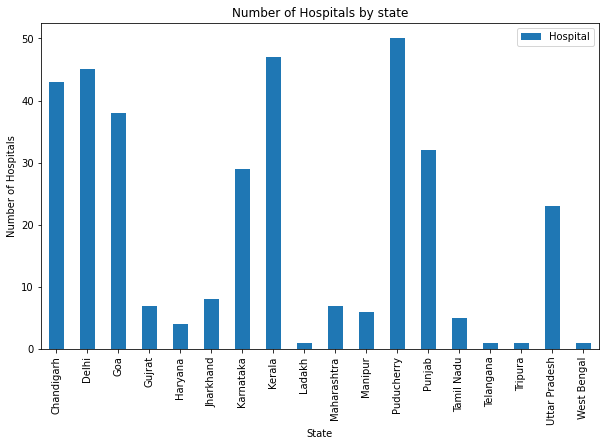

In [134]:
covid_full_hospital_summary.plot(kind='bar', figsize=(10, 6))

plt.xlabel('State') # add to x-label to the plot
plt.ylabel('Number of Hospitals') # add y-label to the plot
plt.title('Number of Hospitals by state') # add title to the plot

plt.show()

In [113]:
KMeans_cluster = 4

<b>Visualization of hospitals in Map </b>

In [121]:
# create map
map_india_hospital = folium.Map(location=[20.59, 78.96], zoom_start=5,tiles='Stamen Terrain') 

# set color scheme for the clusters
x = np.arange(KMeans_cluster)
ys = [i + x + (i*x)**2 for i in range(KMeans_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, hos, cluster in zip(covid_full_hospital_cluster['Hospital_Latitude'], covid_full_hospital_cluster['Hospital_Longitude'], covid_full_hospital_cluster['Hospital'], covid_full_hospital_cluster['Cluster Labels']):
    label = folium.Popup(str(hos) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_india_hospital)
       
map_india_hospital